This code defines the nonlinear model, $$f(x;\theta) = q_1 + q_2*\sin(\pi*q_3*x)$$, and then calculates a finite difference approximation of the model sensitivity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import t


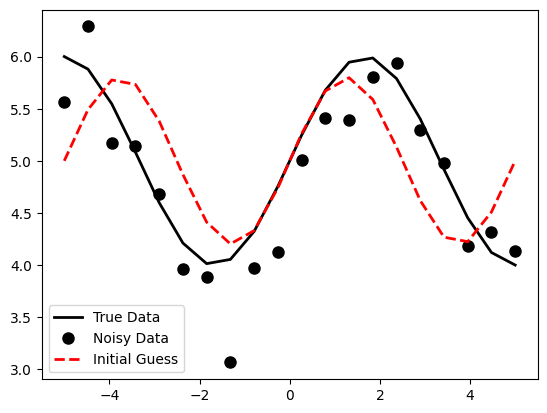

In [2]:

# Define the sine model
def sine_model(q, x):
    return q[0] + q[1] * np.sin(np.pi * q[2] * x)

# Parameters and data
xspace = np.linspace(-5, 5, 20)
param_star = [5, 1, 0.3]
param_guess = [5, 0.8, 0.4]

# Generate data
xspace = np.linspace(-5, 5, 20)
true_data = sine_model(param_star, xspace)
noisy_data = true_data + np.random.normal(0, 0.3, len(xspace))
initial_guess = sine_model(param_guess, xspace)

# Plot initial data and guesses
plt.figure()
plt.clf()
plt.plot(xspace, true_data, '-k', linewidth=2, label='True Data')
plt.plot(xspace, noisy_data, 'ko', markersize=8, label='Noisy Data')
plt.plot(xspace, initial_guess, '--r', linewidth=2, label='Initial Guess')
plt.legend()
plt.show()


Final estimate:
[4.81612302 1.02726596 0.30111967]
True value:
[5, 1, 0.3]


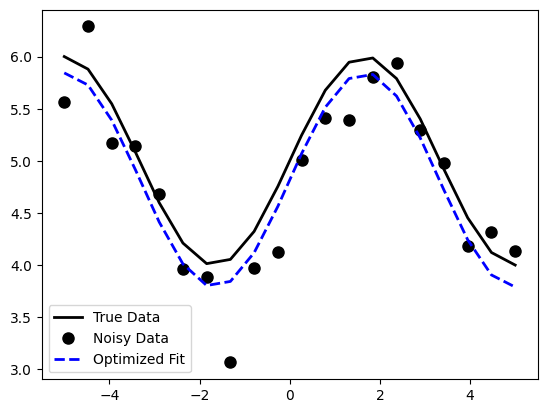

In [4]:
# Define the cost function
def get_nonlin_cost(q, xspace, data):
    sim = sine_model(q, xspace)
    residual = data - sim
    return np.sum(residual**2)

# Perform optimization
result = minimize(get_nonlin_cost, param_guess, args=(xspace, noisy_data))
param_opt = result.x

print('Final estimate:')
print(param_opt)
print('True value:')
print(param_star)

# Plot optimized fit
plt.figure()
plt.plot(xspace, true_data, '-k', linewidth=2, label='True Data')
plt.plot(xspace, noisy_data, 'ko', markersize=8, label='Noisy Data')
plt.plot(xspace, sine_model(param_opt, xspace), '--b', linewidth=2, label='Optimized Fit')
plt.legend()
plt.show()

Parameter CI:
[[4.65337947 4.97886657]
 [0.80000594 1.25452597]
 [0.27438275 0.32785658]]


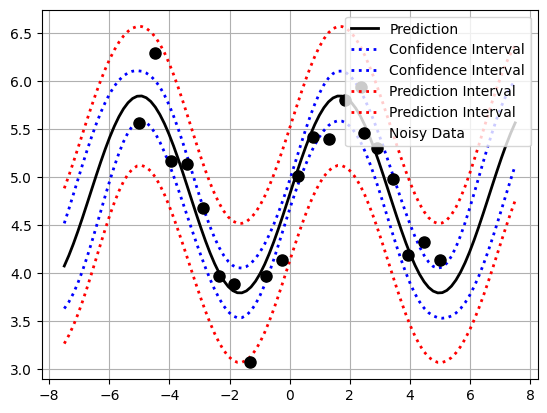

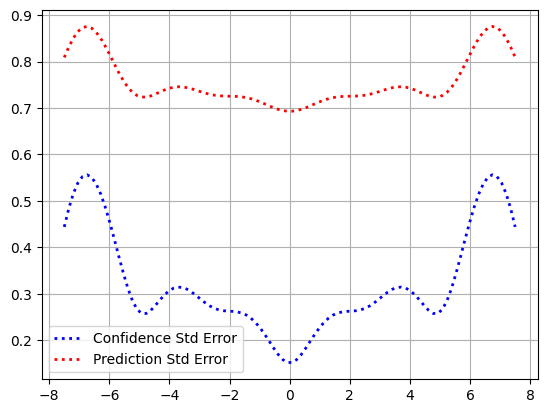

In [7]:
# Construct confidence intervals
# Covariance matrix and confidence intervals
n_xpts = len(xspace)
num_param = len(param_star)
S = np.zeros((n_xpts, num_param))
h = 1e-8

for i in range(num_param):
    param_step = param_opt.copy()
    param_step[i] += h
    S[:, i] = (sine_model(param_step, xspace) - sine_model(param_opt, xspace)) / h

res = noisy_data - sine_model(param_opt, xspace)
s2 = np.dot(res, res) / (n_xpts - num_param)
covar = s2 * np.linalg.inv(S.T @ S)


CI_plus = param_opt + t.ppf(0.975, len(xspace)-len(param_opt)) * np.sqrt(np.diag(covar))
CI_minus = param_opt - t.ppf(0.975, len(xspace)-len(param_opt)) * np.sqrt(np.diag(covar))

print('Parameter CI:')
print(np.vstack((CI_minus, CI_plus)).T)

# Prediction intervals
x_test = np.linspace(1.5 * min(xspace), 1.5 * max(xspace), 100)
n_xtest = len(x_test)
g = np.zeros((n_xtest, num_param))

for i in range(num_param):
    param_step = param_opt.copy()
    param_step[i] += h
    g[:, i] = (sine_model(param_step, x_test) - sine_model(param_opt, x_test)) / h

Y_pred = sine_model(param_opt, x_test)
Y_CI = np.zeros((n_xtest, 2))
Y_PI = np.zeros((n_xtest, 2))
y_stderr_CI = np.zeros(n_xtest)
y_stderr_PI = np.zeros(n_xtest)

for i in range(n_xtest):
    y_stderr_CI[i] = 1.96 * np.sqrt(g[i, :] @ covar @ g[i, :])
    Y_CI[i, 0] = Y_pred[i] + y_stderr_CI[i]
    Y_CI[i, 1] = Y_pred[i] - y_stderr_CI[i]

    y_stderr_PI[i] = 1.96 * np.sqrt(s2 + g[i, :] @ covar @ g[i, :])
    Y_PI[i, 0] = Y_pred[i] + y_stderr_PI[i]
    Y_PI[i, 1] = Y_pred[i] - y_stderr_PI[i]

# Plot the model response, CI, and PI
plt.figure(2)
plt.clf()
plt.plot(x_test, Y_pred, '-k', linewidth=2, label="Prediction")
plt.plot(x_test, Y_CI, ':b', linewidth=2, label="Confidence Interval")
plt.plot(x_test, Y_PI, ':r', linewidth=2, label="Prediction Interval")
plt.plot(xspace, noisy_data, 'ko', markersize=8, label="Noisy Data")
plt.legend()
plt.grid(True)
plt.show()

# Plot standard errors
plt.figure(3)
plt.clf()
plt.plot(x_test, y_stderr_CI, ':b', linewidth=2, label="Confidence Std Error")
plt.plot(x_test, y_stderr_PI, ':r', linewidth=2, label="Prediction Std Error")
plt.legend()
plt.grid(True)
plt.show()